# 4.1 - Macrobond web API - Revision History

*Using Macrobond's web API features to query one or more time series in a point-in-time fashion. Revision history is defined as the feature allowing to request the original values of a time series before it could have been revised by the source. The vintageTimeStamp provides the point-in-time stamp as of which the series was known to have the values retrieved. This time stamp corresponds to when Macrobond has made the data available in its database.*

This notebook aims to provide examples of how to use Macrobond's web API call methods to work with Revision History.

We will focus here on using various calls from observing whether a time series carries Revision History up to requesting the full array of historical revisions.

*Full error handling is omitted for brevity*

***

## Importing packages

In [1]:
# from oauthlib.oauth2 import BackendApplicationClient
# from requests_oauthlib import OAuth2Session
# import json
# import matplotlib.ticker as tck
# import pandas as pd
# import seaborn
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt
# import matplotlib.dates as md
# import getpass as gb
# import numpy as np
# import datetime as dt
# import time


import pandas
from matplotlib import pyplot

from macrobond_financial.common import Credentials
from macrobond_financial.web import WebClient

***

## Authentication

If you have a Macrobond's web API account, enter your *client_id* and *client_secret* below.

In [2]:
credentials = Credentials()

***

## Get the data - GetRevisionInfo

GetRevisionInfo provides high level information whether the time series store Revision History and had Revisions yet or not. The output also provides the list of vintageTimeStamps for series carrying Revision History.

In [3]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.get_revision_info("gbgdp").data_frame()
data_frame

,name,error_message,stores_revisions,has_revisions,time_stamp_of_first_revision,time_stamp_of_last_revision,vintage_time_stamps
0,gbgdp,,True,True,2016-02-25 09:30:00+00:00,2022-05-12 06:01:00+00:00,"(2016-02-25 09:30:00+00:00, 2016-03-31 08:30:0..."


Our time series is enabled to store Revision History and already had revisions. Our records start in 2016-03-31.
Let's now observe the most recent time stamps recorded.

In [4]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    info = api.get_revision_info("gbgdp").object()[0]
list(map(str,info.vintage_time_stamps))[-10:]

['2021-05-20 08:32:00+00:00',
 '2021-06-18 10:31:00+00:00',
 '2021-07-09 11:09:00+00:00',
 '2021-08-12 06:00:00+00:00',
 '2021-09-30 06:01:00+00:00',
 '2021-11-11 07:01:00+00:00',
 '2021-12-22 07:01:00+00:00',
 '2022-02-11 07:01:00+00:00',
 '2022-03-31 06:01:00+00:00',
 '2022-05-12 06:01:00+00:00']

***

## Get the data - FetchObservationHistory

FetchObservationHistory finds the various values a specific historical release 'observationDate' could have had over time. The historical revisions are provided with their respective dates of integration 'timeStamps'.

In [5]:
def downloadMbApi(request):
    url = "https://api.macrobondfinancial.com/v1/" + request
    # This is typically the first time when we do not yet have a token
    if not mbapi.authorized:
        mbapi.fetch_token(
            token_url=token_url, client_id=client_id, client_secret=client_secret
        )
    r = mbapi.get(url)
    if r.status_code != 401:
        return r
    # If authorization failed, it is likely that the token has expired. Get a new one and try again.
    mbapi.fetch_token(
        token_url=token_url, client_id=client_id, client_secret=client_secret
    )
    r = mbapi.get(url)
    return r


# We are fetching here the Q3 2020 observations for gbgdp (United Kingdom GDP).
d = downloadMbApi("series/fetchobservationhistory?n=gbgdp&t=2020-07-01")
x = d.json()

NameError: name 'mbapi' is not defined

In [ ]:
df3 = pd.DataFrame((x), columns=["values", "timeStamps"])
df3 = df3.to_numpy().flatten()
data = pd.DataFrame()
for i in df3:
    df3 = pd.DataFrame(i)
    data = pd.concat([data, df3], axis=1)
data.columns = ["values", "timeStamps"]
data

,values,timeStamps
0,490861000000,2021-02-12T07:00:00Z
1,497909000000,2021-03-31T06:00:00Z
2,497401000000,2021-05-12T07:00:00Z
3,498429000000,2021-05-20T08:32:00Z


**Review TO: Do we really want to quote specific observations and values here? The underlying data will change and the text will be wrong.**
As we have requested here the historical value of GB GDP accounting for Q3 2020, we can see that it was originally published on 2021-02-12 at 7AM UTC with a value of 490,861,000,000.
This Q3 2020 GB GDP was then further revised 3 times with the latest revision to date published on 2021-05-20 at 8.32AM UTC with a value of 498,429,000,000.

Let's measure the time difference from the first publication to the last revision:

In [ ]:
data.timeStamps = pd.to_datetime(data.timeStamps)
data.timeStamps.max() - data.timeStamps.min()

Timedelta('97 days 01:32:00')

Let's plot our revisions

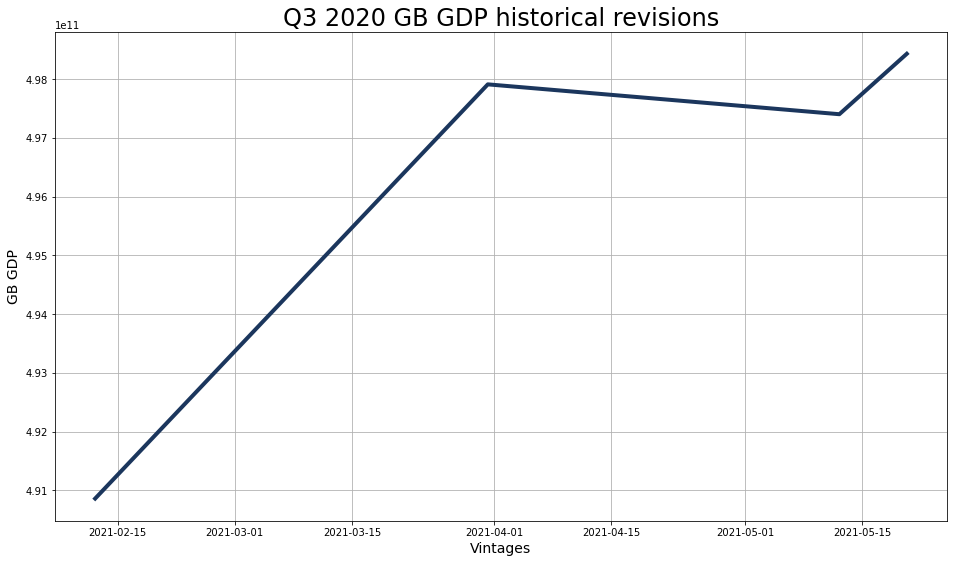

In [ ]:
plt.rcParams["figure.figsize"] = [16, 9]

fig, ax = plt.subplots()
ax.plot(
    data["timeStamps"],
    data["values"],
    color=(27 / 255, 54 / 255, 93 / 255),
    linewidth=4,
)
plt.title("Q3 2020 GB GDP historical revisions", fontsize=24)
plt.xlabel("Vintages", fontsize=14)
plt.ylabel("GB GDP", fontsize=14)
ax.grid()
plt.autoscale()
plt.show()

***

## Get the data - FetchNthReleaseSeries

FetchNthReleaseSeries retrieves the nth change of value of the requested time series.
Now that we have pulled out the revisions of a specific time series for a fixed observation via the FetchObservationHistory endpoint, we can isloate the nth revision in this array. This can be particularly useful to observe patterns of revisions from a single source or on a unique concept across various regions.  

In [ ]:
# We are fetching here the first revision (n=1) for each observation of gbgdp (United Kingdom GDP).
d = downloadMbApi("series/fetchnthreleaseseries?nth=1&getTimesOfChange=true&n=gbgdp")
x = d.json()

with WebClient(credentials.client_id, credentials.client_secret) as api:
    info = api.revision.get_revision_info("gbgdp").object()[0]
list(map(str,info.vintage_time_stamps))[-10:]

As we are fetching the first revision for each observation, let's bear in mind that the very first vintage recorded for this series was on 2016-03-31 i.e. there was no revision recorded beforehand hence we can expect to see no timesOfChange nor values prior to this date.

In [ ]:
df4 = pd.DataFrame((x), columns=["timesOfChange", "dates", "values"])
df4 = df4.to_numpy().flatten()
data = pd.DataFrame()
for i in df4:
    df4 = pd.DataFrame(i)
    data = pd.concat([data, df4], axis=1)
data.columns = ["timesOfChange", "dates", "values"]
data.dates = pd.to_datetime(data.dates, dayfirst=True)
data.sort_values(by="dates", ascending=False)

,timesOfChange,dates,values
265,None,2021-04-01,NaN
264,2021-06-30T06:00:00Z,2021-01-01,4.971450e+11
263,2021-05-20T08:32:00Z,2020-10-01,5.047420e+11
262,2021-03-31T06:00:00Z,2020-07-01,4.979090e+11
261,2020-10-27T15:59:00Z,2020-04-01,4.249620e+11
...,...,...,...
4,None,1956-01-01,NaN
3,None,1955-10-01,NaN
2,None,1955-07-01,NaN
1,None,1955-04-01,NaN


**Review TO: Do we really want to quote specific observations and values here? New values will be added to this series, and value 262 will no longer be listed above.**

We observe here on row 262 the timeOfChange = 2021-03-31T06:00:00Z and value 497,909,000,000 that we previously returned when using FetchObservationHistory on Q3 2020 for this series. 

***

## Get the data - FetchVintageSeries

In [ ]:
# We are fetching here the the gbgdp (United Kingdom GDP) as of 2020-06-30, which is the vintage we have been referring to before.
d = downloadMbApi(
    "series/fetchvintageseries?t=2020-07-01&getTimesOfChange=false&n=gbgdp"
)
x = d.json()

Note that we have inserted the time of the vintage to retrieve in the query = 2020-07-01 which is one day after the actual vintage in order to make sure we fall back on the most recent one prior to this date, which is 2020-06-30. We also could have been using a time stamp just after 06:00:00Z as this is when the vintage was recorded. 

In [ ]:
df5 = pd.DataFrame((x), columns=["vintageTimeStamp"])
df5

,vintageTimeStamp
0,2020-06-30T06:00:00Z


Let's now observe the time series as it was as of that date:

In [ ]:
df6 = pd.DataFrame((x), columns=["dates", "values"])
df6 = df6.to_numpy().flatten()
data_pit = pd.DataFrame()
for i in df6:
    df6 = pd.DataFrame(i)
    data_pit = pd.concat([data_pit, df6], axis=1)
data_pit.columns = ["dates", "values"]
data_pit

,dates,values
0,1955-01-01T00:00:00,112194000000
1,1955-04-01T00:00:00,112267000000
2,1955-07-01T00:00:00,114538000000
3,1955-10-01T00:00:00,113938000000
4,1956-01-01T00:00:00,115274000000
...,...,...
255,2018-10-01T00:00:00,518136000000
256,2019-01-01T00:00:00,521610000000
257,2019-04-01T00:00:00,520779000000
258,2019-07-01T00:00:00,523513000000


Let's now plot our time series as of this specific vintage time stamp:

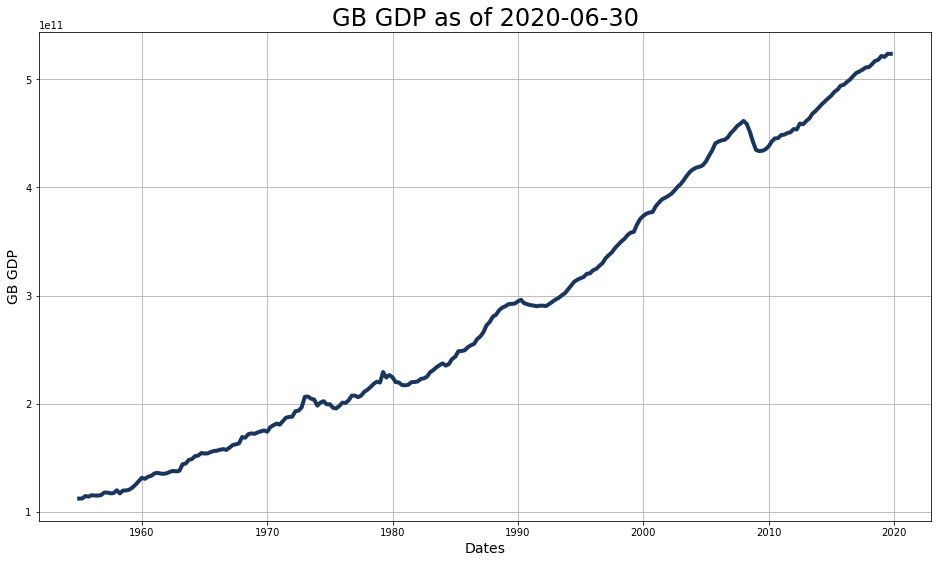

In [ ]:
dates_h = pd.to_datetime(data_pit.dates)

plt.rcParams["figure.figsize"] = [16, 9]

fig, ax = plt.subplots()
ax.plot(dates_h, data_pit["values"], color=(27 / 255, 54 / 255, 93 / 255), linewidth=4)
plt.title("GB GDP as of 2020-06-30", fontsize=24)
plt.xlabel("Dates", fontsize=14)
plt.ylabel("GB GDP", fontsize=14)
ax.grid()
plt.autoscale()
plt.show()

***

## Get the data - FetchAllVintageSeries

FetchAllVintageSeries retrieves the full array of revisions over time for the requested time series.
We can build a dataframe of such revisions. 

In [ ]:
# We are fetching here the the gbgdp (United Kingdom GDP) as of 2020-06-30, which is the vintage we have been referring to before.
d = downloadMbApi("series/fetchallvintageseries?n=gbgdp")
x = d.json()

In [ ]:
data = pd.DataFrame(x)
s = data
data.vintageTimeStamp = pd.to_datetime(data.vintageTimeStamp, dayfirst=True)


vintageTimeStamp = data["vintageTimeStamp"].values
data = data.drop(["metadata", "vintageTimeStamp"], axis=1)
df1 = data.to_numpy().flatten()
# ----------------------------------------
df = pd.DataFrame()
for i in df1:
    df2 = pd.DataFrame(i)
    df = pd.concat([df, df2], axis=1)
i = 1
sn = []
for j in range(len(df.columns) // 2):
    series1 = pd.DataFrame(df.iloc[:, i - 1])
    series2 = pd.DataFrame(df.iloc[:, i])
    sn1 = pd.concat([series1, series2], axis=1)
    l = str(vintageTimeStamp[(i - 1) // (2)])
    sn1.columns = ["dates", l]
    sn1 = sn1.set_index("dates")
    sn1.index.name = None
    sn1 = sn1.squeeze()
    sn1 = sn1[np.logical_not(np.isnan(sn1))]
    sn.append(sn1)
    i = i + 2

dff = pd.DataFrame(sn)
data = dff.T
data

,NaT,2016-03-31T08:30:00.000000000,2016-04-01T14:30:00.000000000,2016-04-28T10:55:00.000000000,2016-06-30T08:30:00.000000000,2016-07-01T11:33:00.000000000,2016-08-26T08:30:00.000000000,2016-09-30T08:30:00.000000000,2016-11-25T09:30:00.000000000,2016-12-23T09:30:00.000000000,...,2020-11-12T07:00:00.000000000,2020-12-22T06:10:00.000000000,2021-02-12T07:00:00.000000000,2021-03-31T06:00:00.000000000,2021-05-12T07:00:00.000000000,2021-05-20T08:32:00.000000000,2021-06-18T10:31:00.000000000,2021-06-30T06:00:00.000000000,2021-07-09T11:09:00.000000000,2021-08-12T06:00:00.000000000
1955-01-01T00:00:00,1.038400e+11,1.038400e+11,1.038400e+11,1.038400e+11,1.038400e+11,1.072630e+11,1.038400e+11,1.072630e+11,1.072630e+11,1.072630e+11,...,1.121940e+11,1.099670e+11,1.099670e+11,1.099670e+11,1.099670e+11,1.099670e+11,1.165320e+11,1.165320e+11,1.165320e+11,1.165320e+11
1955-04-01T00:00:00,1.039700e+11,1.039700e+11,1.039700e+11,1.039700e+11,1.039700e+11,1.073980e+11,1.039700e+11,1.073980e+11,1.073980e+11,1.073980e+11,...,1.122670e+11,1.100870e+11,1.100870e+11,1.100870e+11,1.100870e+11,1.100870e+11,1.166370e+11,1.166370e+11,1.166370e+11,1.166370e+11
1955-07-01T00:00:00,1.060980e+11,1.060980e+11,1.060980e+11,1.060980e+11,1.060980e+11,1.095910e+11,1.060980e+11,1.095910e+11,1.095910e+11,1.095910e+11,...,1.145380e+11,1.123330e+11,1.123330e+11,1.123330e+11,1.123330e+11,1.123330e+11,1.189970e+11,1.189970e+11,1.189970e+11,1.189970e+11
1955-10-01T00:00:00,1.055240e+11,1.055240e+11,1.055240e+11,1.055240e+11,1.055240e+11,1.090500e+11,1.055240e+11,1.090500e+11,1.090500e+11,1.090500e+11,...,1.139380e+11,1.117310e+11,1.117310e+11,1.117310e+11,1.117310e+11,1.117310e+11,1.183510e+11,1.183510e+11,1.183510e+11,1.183510e+11
1956-01-01T00:00:00,1.066690e+11,1.066690e+11,1.066690e+11,1.066690e+11,1.066690e+11,1.102010e+11,1.066690e+11,1.102010e+11,1.102010e+11,1.102010e+11,...,1.152740e+11,1.129520e+11,1.129520e+11,1.129520e+11,1.129520e+11,1.129520e+11,1.197350e+11,1.197350e+11,1.197350e+11,1.197350e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.080460e+11,4.249620e+11,4.249620e+11,4.292190e+11,4.283070e+11,4.261970e+11,4.261970e+11,4.261970e+11,4.261970e+11,4.261970e+11
2020-07-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.908610e+11,4.979090e+11,4.974010e+11,4.984290e+11,4.984290e+11,4.984290e+11,4.984290e+11,4.984290e+11
2020-10-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.022530e+11,5.047420e+11,5.047420e+11,5.047420e+11,5.047420e+11,5.047420e+11
2021-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.971450e+11,4.971450e+11,4.971450e+11,4.967370e+11,4.967370e+11
